In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import h5py

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

from pathlib import Path

from tqdne.utils import load_model, generate_data, get_samples, plot_waveform_and_psd, plot_waveforms, plot_by_bins, plot_log_envelope_bins, get_cond_params_dict
from tqdne.conf import Config
from tqdne.metric import *

/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.empty_cache()
else: 
    device = torch.device('cpu')

torch.cuda.is_available(), device

(True, device(type='cuda'))

# GM0 Performance Evaluation

In [3]:
config = Config()

# Select the signal length
signal_length = config.signal_length 

# Set the number of channels of the desired output signal  
n_channels = config.num_channels

# Set the sampling frequency
fs = config.fs

# Set the conditioning parameters range
cond_params_range = config.conditional_params_range

In [4]:
!ls ..

archive			run-scripts	    slurm-52242192.out
CHANGELOG.rst		slurm-52115529.out  slurm-52265673.out
datasets		slurm-52125040.out  slurm-52265742.out
docs			slurm-52130391.out  slurm-52267188.out
environment.yaml	slurm-52130921.out  slurm-52279621.out
experiments		slurm-52131219.out  slurm-52279661.out
MANIFEST.in		slurm-52131274.out  slurm-52280731.out
merged_logenv_figs.png	slurm-52206086.out  slurm-52305124.out
model.svg		slurm-52218359.out  slurm-52315455.out
my_environment.yaml	slurm-52224916.out  target_inv_is_working.png
notebooks		slurm-52225324.out  tox.ini
outputs			slurm-52228974.out  tqdne
pred_logenv_fig.png	slurm-52229642.out  tqdne.egg-info
pyproject.toml		slurm-52232449.out  wandb
README.rst		slurm-52233463.out


In [5]:
!ls -l ../outputs/ddpm-pred:sample-1D_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05-normalize-scalar:True

total 983644
drwxr-xr-x 12 abosisio sd28     4096 Mar 21 01:53  lightning_logs
-rw-r--r--  1 abosisio sd28 91694363 Mar 19 01:14 'name=0_epoch=11-val_loss=0.17-v1.ckpt'
-rw-r--r--  1 abosisio sd28 91694427 Mar 19 07:59 'name=0_epoch=21-val_loss=0.17-v1.ckpt'
-rw-r--r--  1 abosisio sd28 91694363 Mar 19 12:05 'name=0_epoch=27-val_loss=0.17.ckpt'
-rw-r--r--  1 abosisio sd28 91455516 Mar 19 12:02 'name=0_epoch=30-val_loss=0.17.ckpt'
-rw-r--r--  1 abosisio sd28 91694427 Mar 19 14:11 'name=0_epoch=30-val_loss=0.17-v1.ckpt'
-rw-r--r--  1 abosisio sd28 91694363 Mar 19 15:33 'name=0_epoch=31-val_loss=0.17.ckpt'
-rw-r--r--  1 abosisio sd28 91458972 Mar 20 13:02 'name=0_epoch=45-val_loss=0.17.ckpt'
-rw-r--r--  1 abosisio sd28 91458972 Mar 20 19:53 'name=0_epoch=55-val_loss=0.17.ckpt'
-rw-r--r--  1 abosisio sd28 91458972 Mar 20 20:37 'name=0_epoch=56-val_loss=0.17.ckpt'
-rw-r--r--  1 abosisio sd28 91458972 Mar 20 23:22 'name=0_epoch=60-val_loss=0.17.ckpt'
-rw-r--r--  1 abosisio sd28 91458972 Mar 2

In [6]:
model_path_str = "../outputs/ddpm-pred:sample-1D_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05-normalize-scalar:True"

#model, model_data_repr = load_model_by_name('diffusion_1d', map_location=device, path=Path(model_path_str))
model, model_data_repr = load_model(Path(model_path_str), use_ddim=False)
model.to(device)
model.eval()
print(model)

2024-03-21 02:14:07 - root - INFO - Last checkpoint is : ../outputs/ddpm-pred:sample-1D_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05-normalize-scalar:True/name=0_epoch=62-val_loss=0.17.ckpt


LightningDiffusion(
  (net): UNetModel(
    (time_embed): GaussianFourierProjection()
    (time_mlp): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (cond_mlp): Sequential(
      (0): Linear(in_features=5, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv1d(6, 32, kernel_size=(3,), stride=(1,), padding=same)
      )
      (1-2): 2 x TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=same)
          )
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=128, out_features=32, bias=True)
      

/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [7]:
from torchview import draw_graph
from tqdne.utils import generate_data
import torch

bs = 4

gen_example = generate_data(model, model_data_repr, True, bs)
input_data_example = {
    "x": torch.from_numpy(gen_example["waveforms"]).float(), 
    #"input": gen_example["waveforms"], 
    "timesteps": torch.randint(0, 10, (bs,)).long(),
    #"cond_signal": gen_example["waveforms"][:, :, :30], 
    "cond": torch.from_numpy(gen_example["cond"]).float(),
    }
input_data_example_shape = [v.shape for k, v in input_data_example.items() if v is not None]

model_graph = draw_graph(model.net, input_data=input_data_example, expand_nested=True)
#model_graph.visual_graph

2024-03-21 02:14:16 - root - WARNING - No conditional input provided. Generating random conditional inputs.


hypocentral_distance (0.0, 200.0)
is_shallow_crustal (0.0, 1.0)
log10snr (-2.0, 40)
magnitude (3.0, 10)
vs30 (-1.0, 2100.0)


100%|██████████| 1000/1000 [00:22<00:00, 43.64it/s]


Let's generate a batch of data:

In [8]:
# Select the batch size
batch_size = 64

In [9]:
# Insert values for the conditional input parameters.
# Please read generate_cond_inputs documentation (in utils.py) to understand the structure of cond_input_params dictionary
cond_input_params = {
    "hypocentral_distance": [10, 100, 150],
    "is_shallow_crustal": [0],
    "log10snr": [0, 10],
    "magnitude": [2, 1, 3, 7],
    "vs30": None,
}

data_raw = generate_data(model, model_data_representation=model_data_repr, raw_output=True, batch_size=batch_size, cond_input_params=cond_input_params, device=device.type)
data_raw['waveforms'].shape, data_raw['cond'].shape

#DEBUG
#import pickle
#from tqdne import representations 
#with open('data.pickle', 'rb') as f:
#    data, cond_input = pickle.load(f)
#    data = representations.to_numpy(data)
#    cond_input = representations.to_numpy(cond_input)
#    data = {'waveforms': np.array(data), 'cond': np.array(cond_input)}
#data['waveforms'].shape, data['cond'].shape

hypocentral_distance [10, 100, 150]
is_shallow_crustal [0]
log10snr [0, 10]
magnitude [2, 1, 3, 7]
vs30 None


100%|██████████| 1000/1000 [04:09<00:00,  4.02it/s]


((64, 6, 5472), (64, 5))

In [10]:
data_raw_wf = data_raw['waveforms']
data_raw_wf.shape

(64, 6, 5472)

In [11]:
np.max(data_raw_wf, axis=(1,2)), np.min(data_raw_wf, axis=(1,2))

(array([1.0752963, 1.07695  , 1.0309663, 1.120764 , 1.0822612, 1.1021442,
        1.0727348, 1.1492275, 1.1486852, 1.1251752, 1.1759691, 1.1053956,
        1.1513665, 1.2942654, 1.1216104, 1.7289492, 1.0408481, 1.1736544,
        1.0986072, 1.0889766, 1.1995109, 1.0590905, 1.1468874, 1.246532 ,
        1.1213928, 2.0375335, 1.2021325, 1.3170533, 1.133235 , 1.1981038,
        1.2388815, 1.1019096, 1.1718696, 2.0589845, 1.0704023, 1.0685881,
        1.2089404, 2.3821275, 1.283786 , 1.3459953, 1.1364789, 1.2638026,
        1.0684929, 1.1145476, 1.17885  , 1.1466836, 1.810121 , 1.2472699,
        1.5367539, 1.926556 , 1.0957043, 1.1013362, 1.0866826, 1.1208735,
        1.091548 , 1.2984507, 1.093209 , 1.2518892, 1.1867917, 1.0999001,
        1.0851501, 1.216196 , 1.132379 , 1.3129935], dtype=float32),
 array([-1.7055806, -1.2902167, -1.4366301, -1.3039157, -1.2159638,
        -1.2330618, -1.0957539, -1.1557952, -1.2775217, -1.293763 ,
        -1.4070443, -1.266065 , -1.3072795, -1.2601234,

In [12]:
data_wf = model_data_repr.invert_representation(data_raw_wf)
data_wf.shape

(64, 3, 5472)

In [13]:
finite_max = np.max(data_wf[np.isfinite(data_wf)])
finite_min = np.min(data_wf[np.isfinite(data_wf)])

np.min(data_wf), finite_min, np.max(data_wf), finite_max

(-58590.539429520904,
 -58590.539429520904,
 120825.50288193754,
 120825.50288193754)

In [14]:
def plot_raw_waveform(raw_waveform, n_channels, waveform=None):
    if waveform is not None:
        fig, axs = plt.subplots(n_channels, 3, figsize=(15, 15))
        for c in range(n_channels):
            axs[c, 0].plot(raw_waveform[c, :])
            axs[c, 1].plot(raw_waveform[n_channels+c, :])
            axs[c, 2].plot(waveform[c, :])
    else:
        fig, axs = plt.subplots(n_channels, 2, figsize=(15, 15))
        for c in range(n_channels):
            axs[c, 0].plot(raw_waveform[c, :])
            axs[c, 1].plot(raw_waveform[n_channels+c, :])

    plt.show()

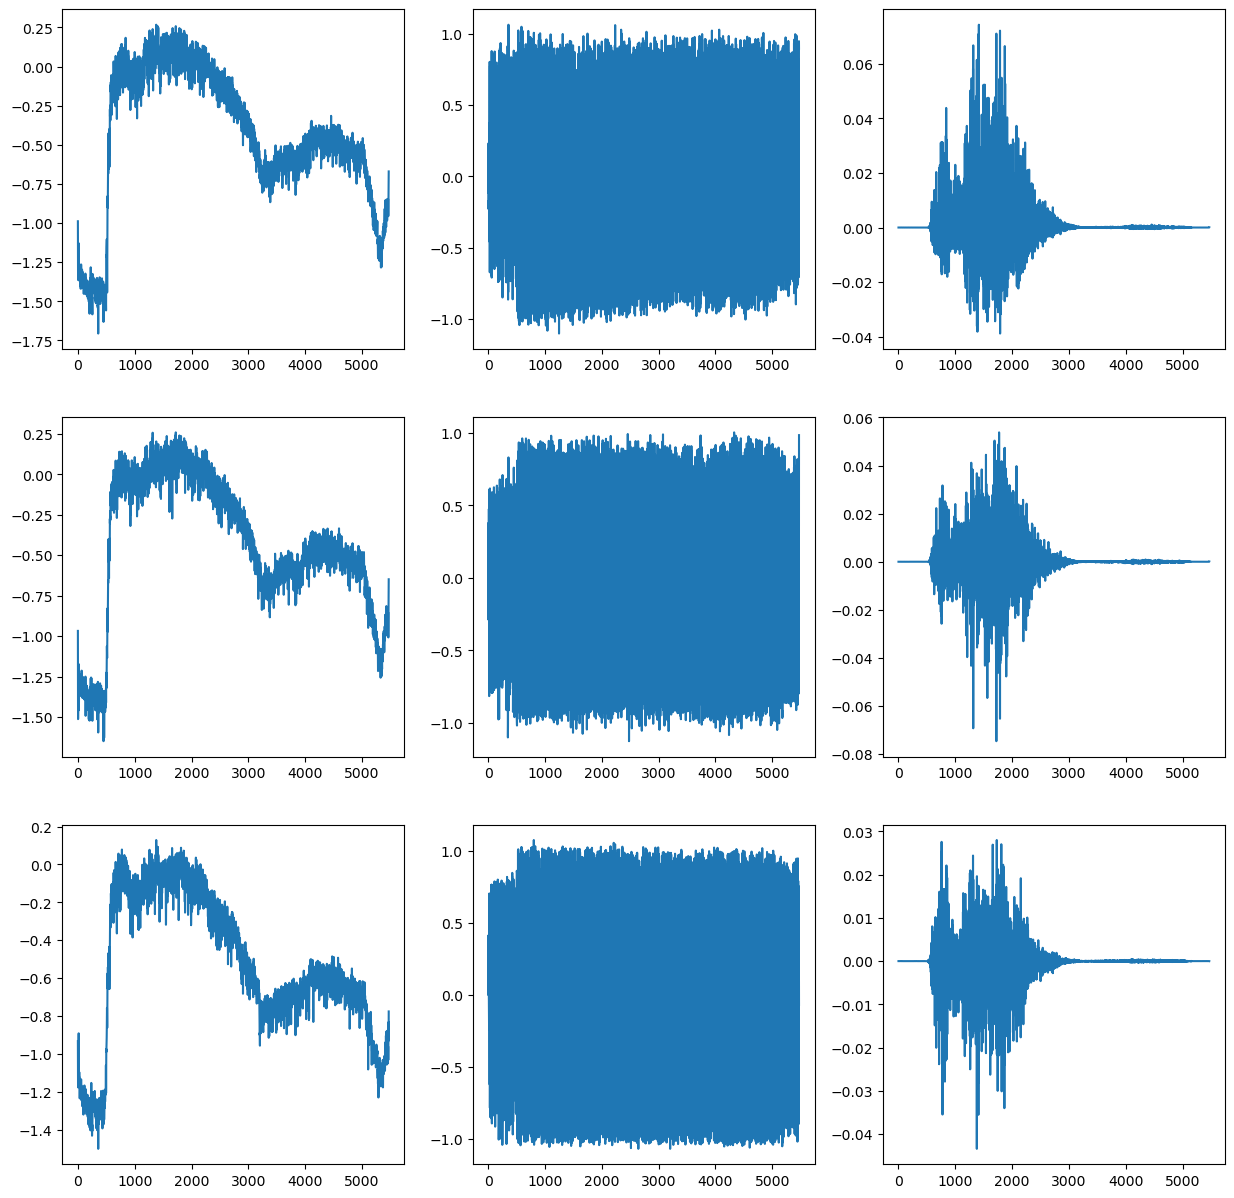

In [15]:
plot_raw_waveform(data_raw_wf[0], n_channels, data_wf[0])

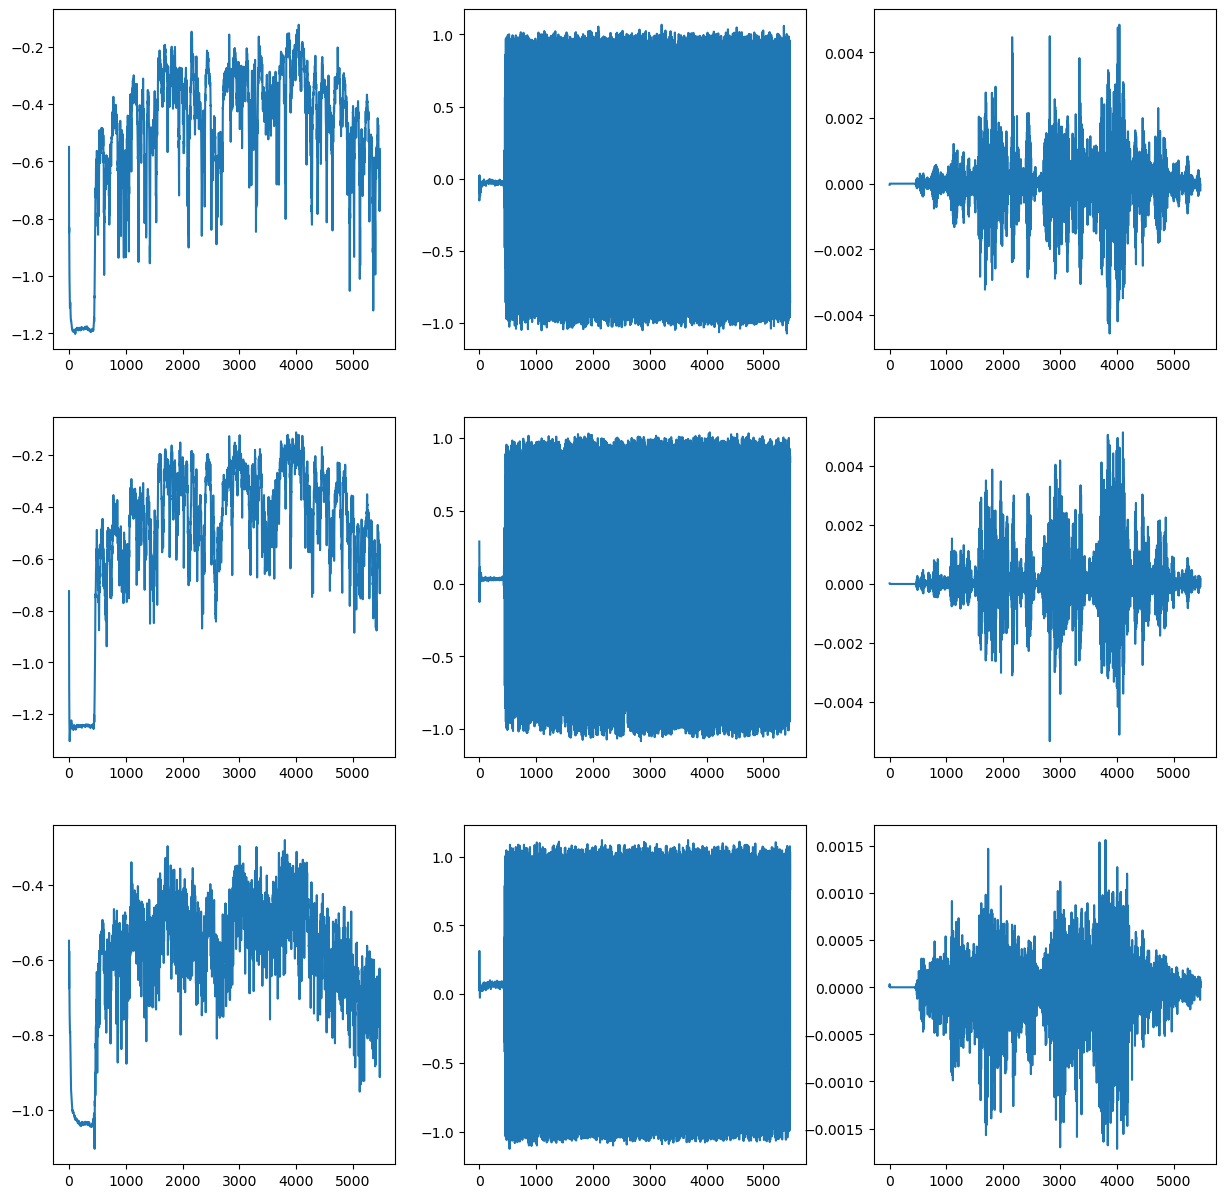

In [16]:
plot_raw_waveform(data_raw_wf[3], n_channels, data_wf[3])

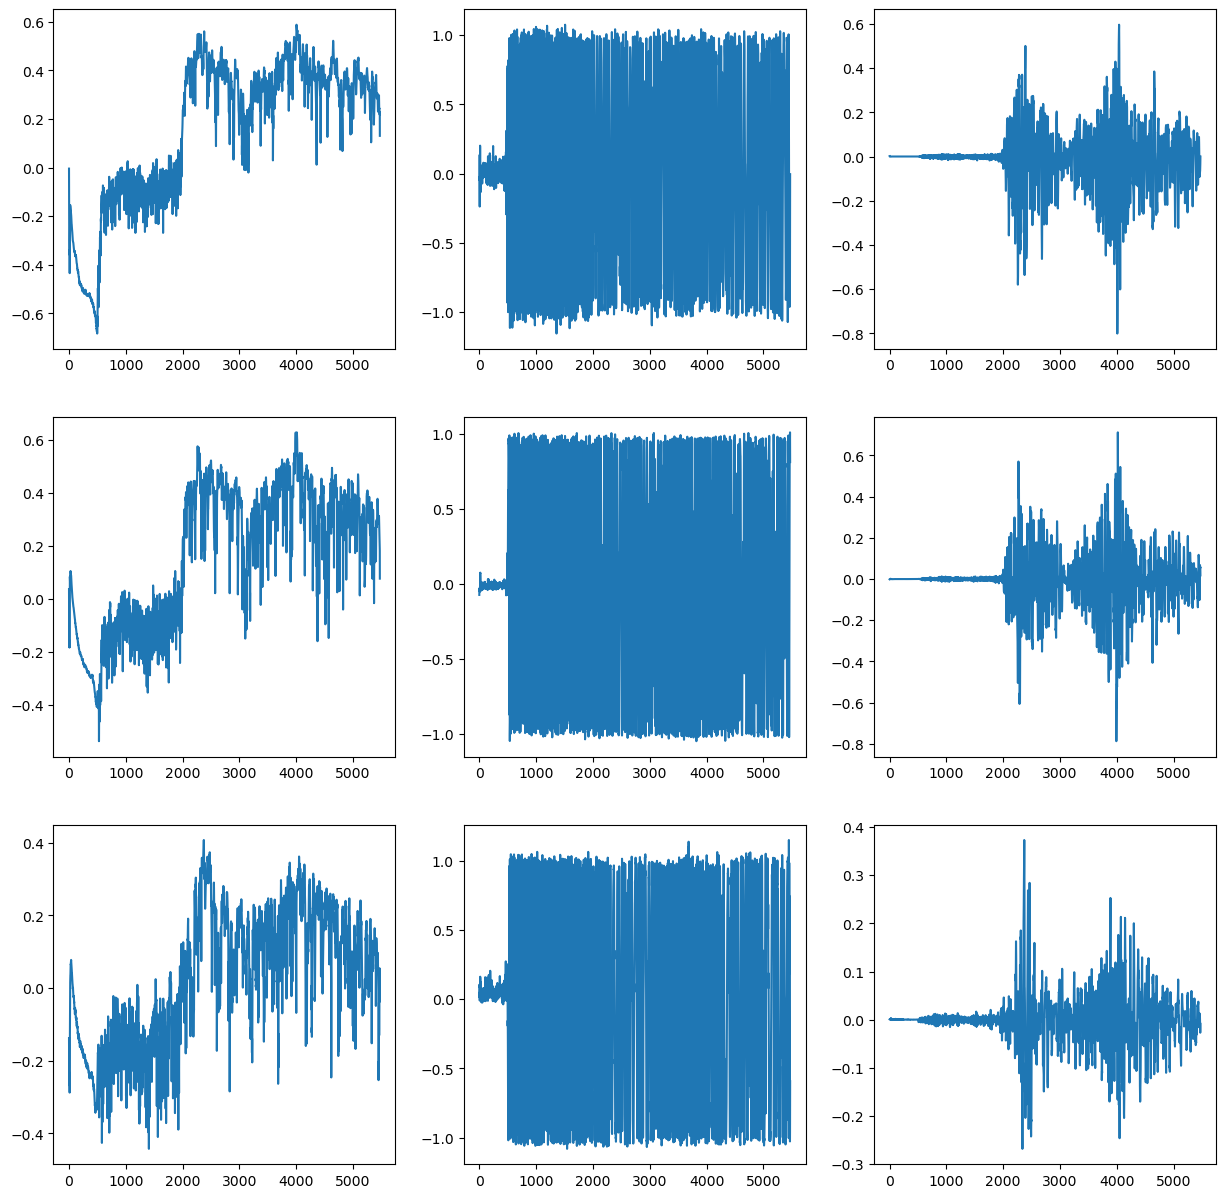

In [17]:
plot_raw_waveform(data_raw_wf[7], n_channels, data_wf[7])

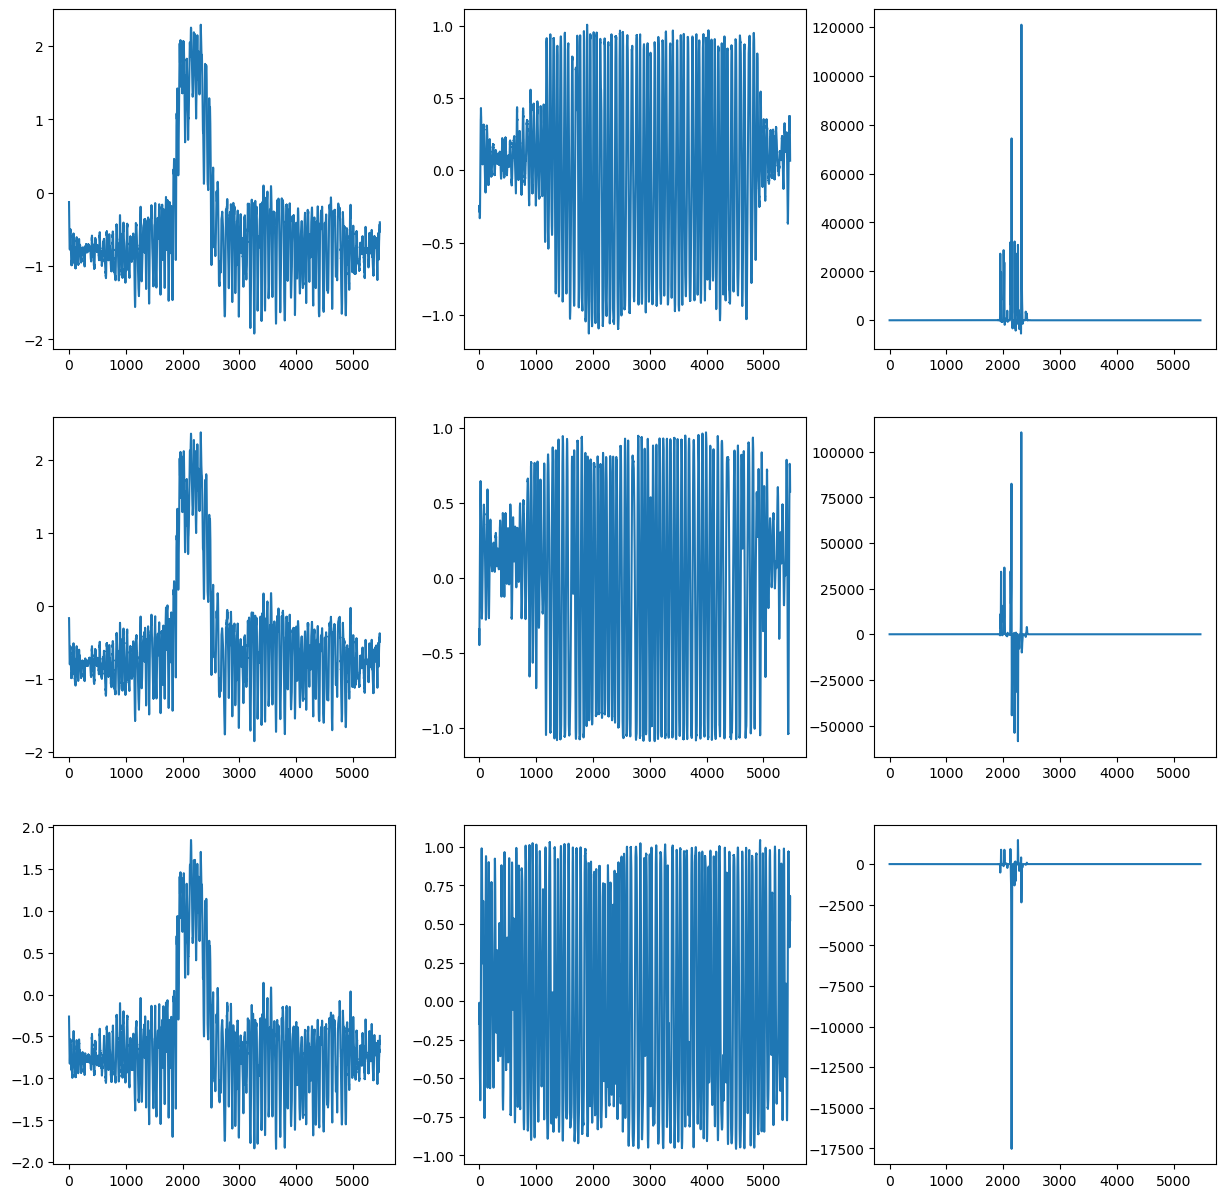

In [20]:
max_peak_index = np.argmax(np.max(data_raw_wf, axis=(1, 2)))
plot_raw_waveform(data_raw_wf[max_peak_index], n_channels, data_wf[max_peak_index])

## Single Sample Visualization

In [21]:
data = {"waveforms": data_wf, "cond": data_raw['cond']}

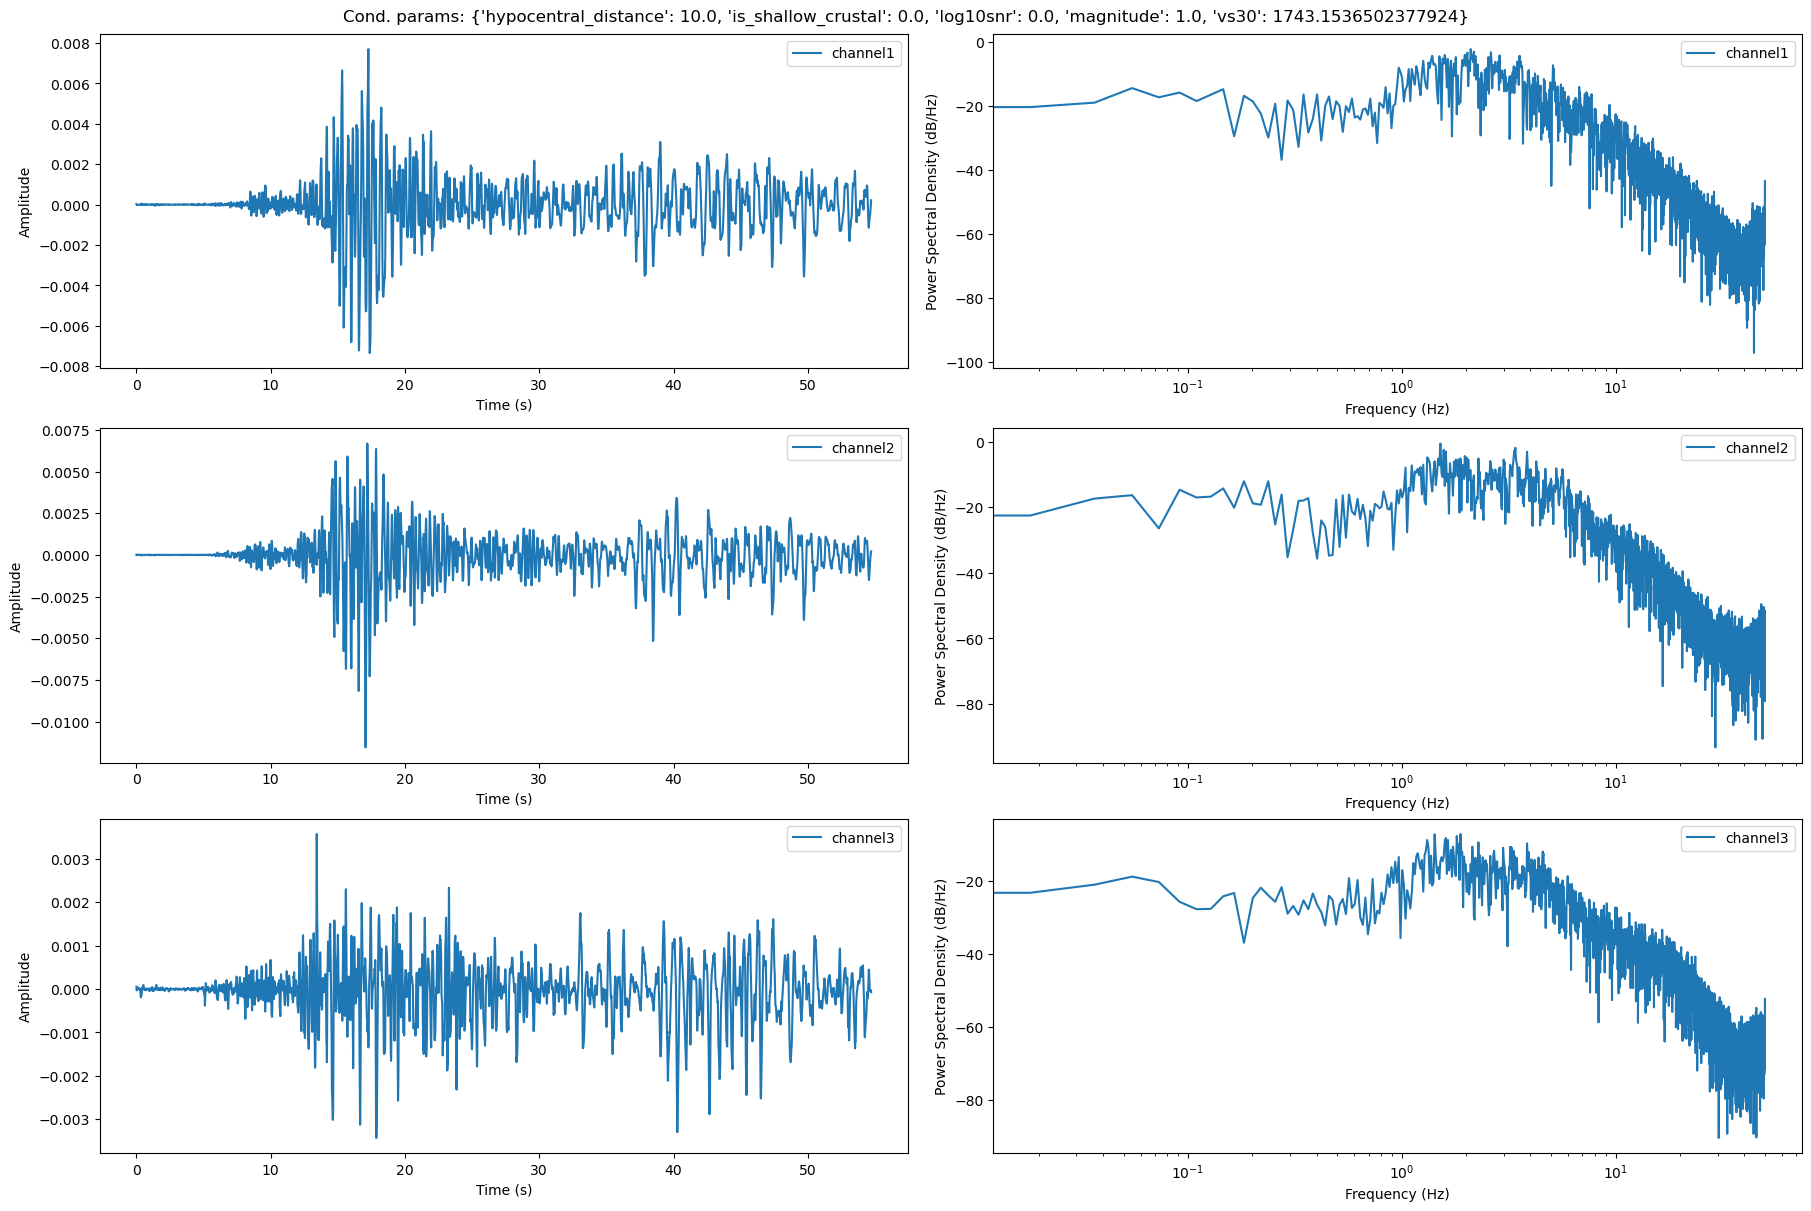

In [22]:
plot_waveform_and_psd(get_samples(data, num_samples=1))

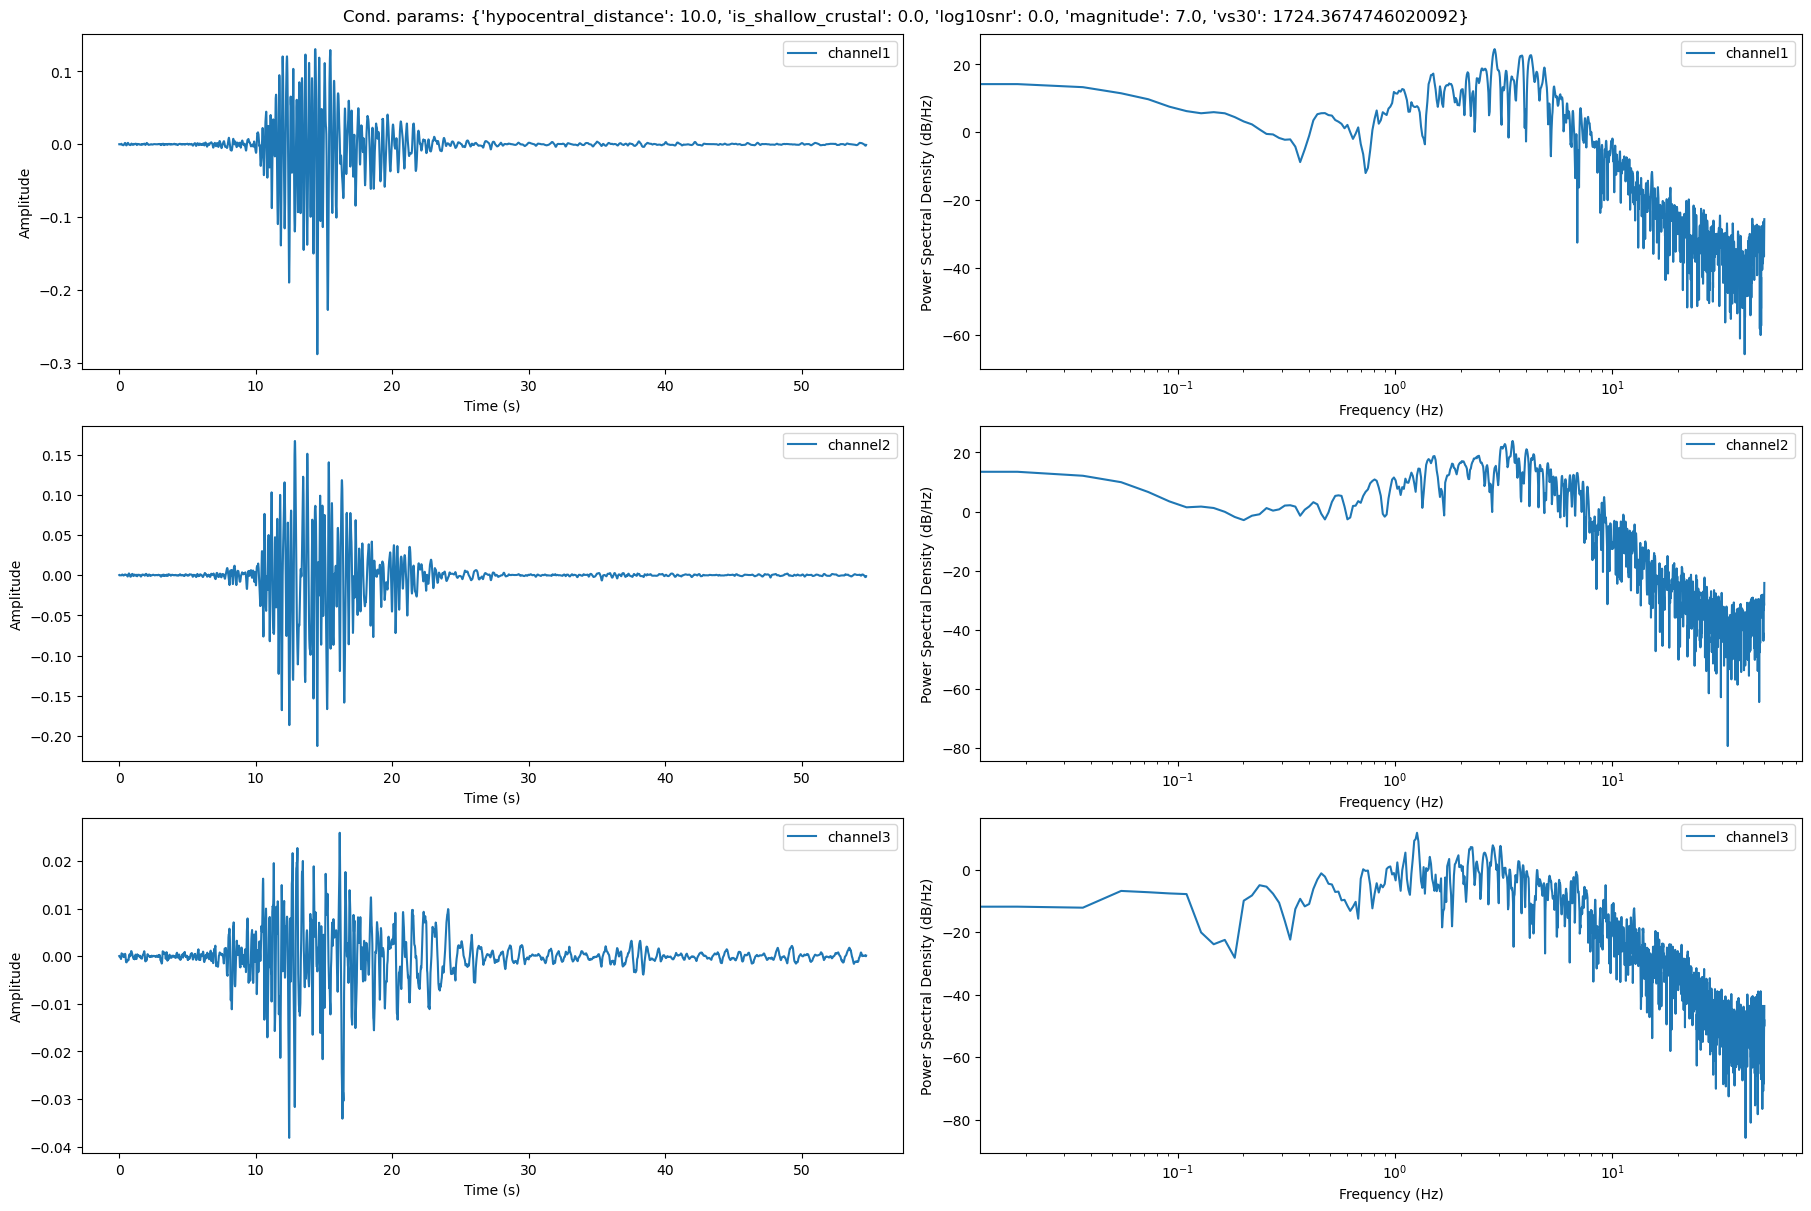

In [23]:
plot_waveform_and_psd(get_samples(data, indexes=[2]))

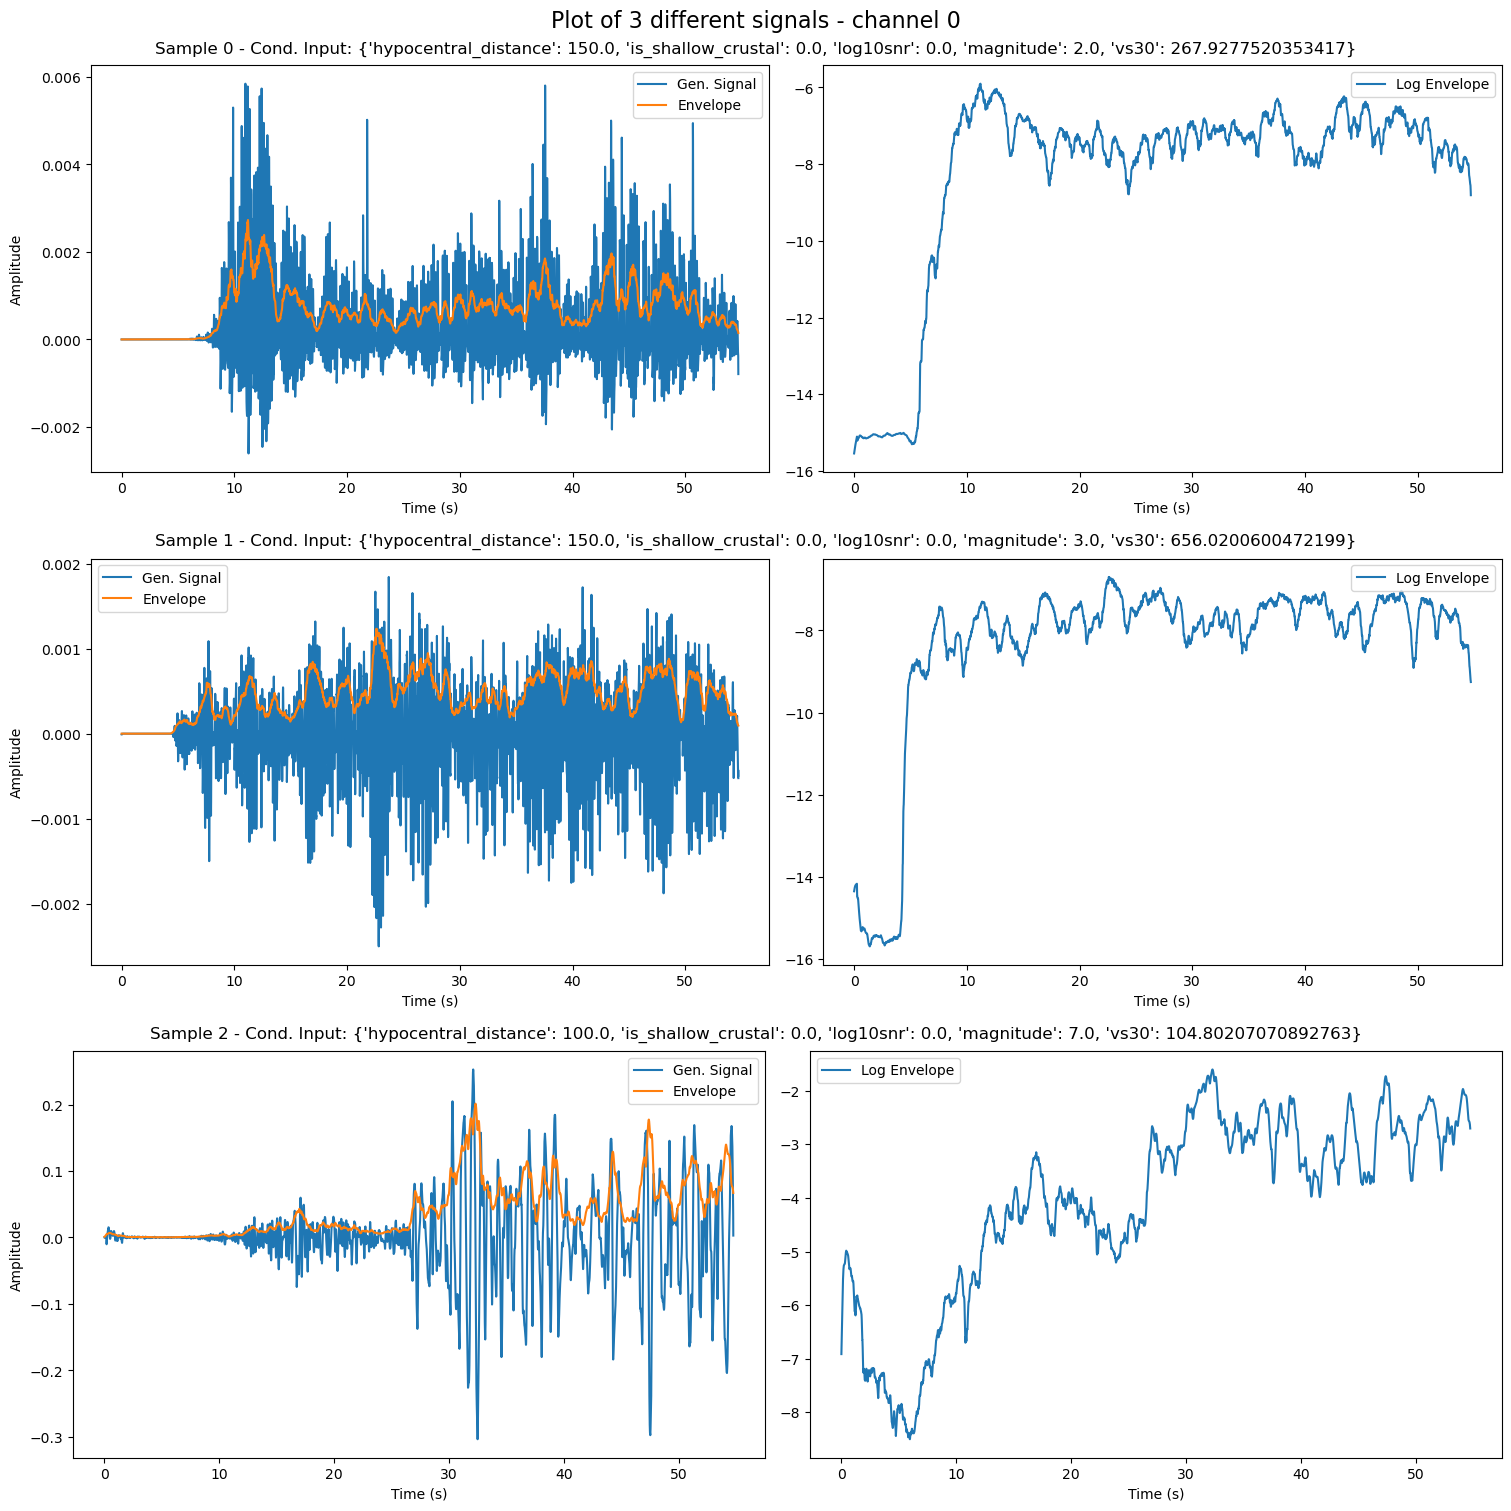

In [24]:
plot_waveforms(get_samples(data, num_samples=3), channel_index=0, plot_log_envelope=True)

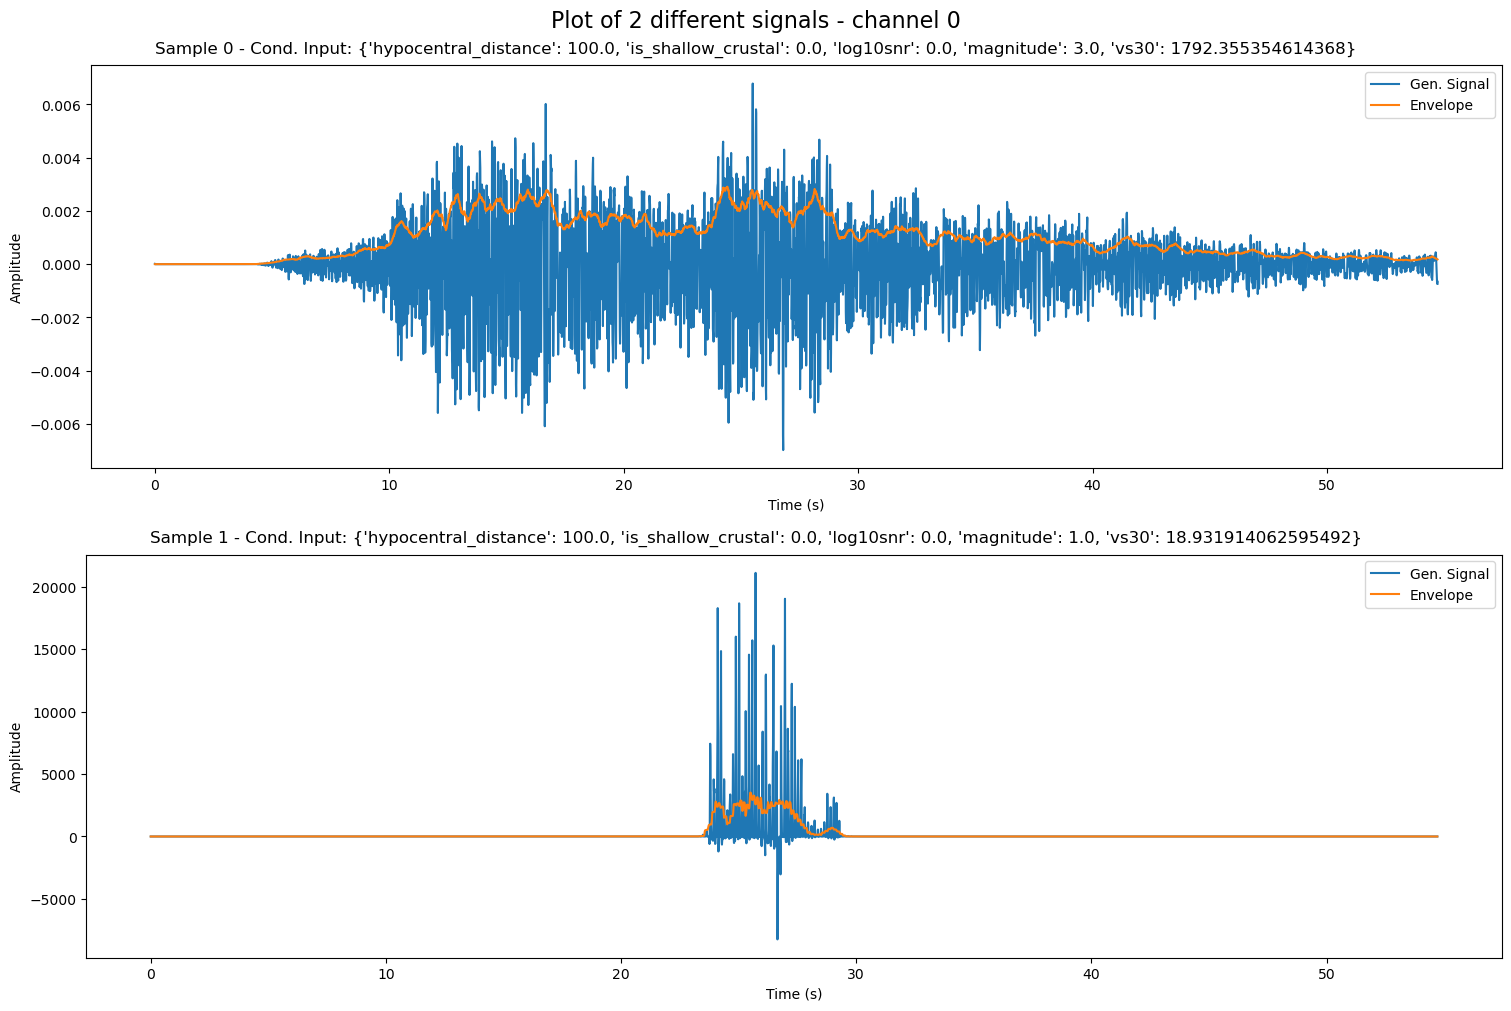

In [25]:
plot_waveforms(get_samples(data, num_samples=2), channel_index=0, plot_log_envelope=False)

## Batch Statistics

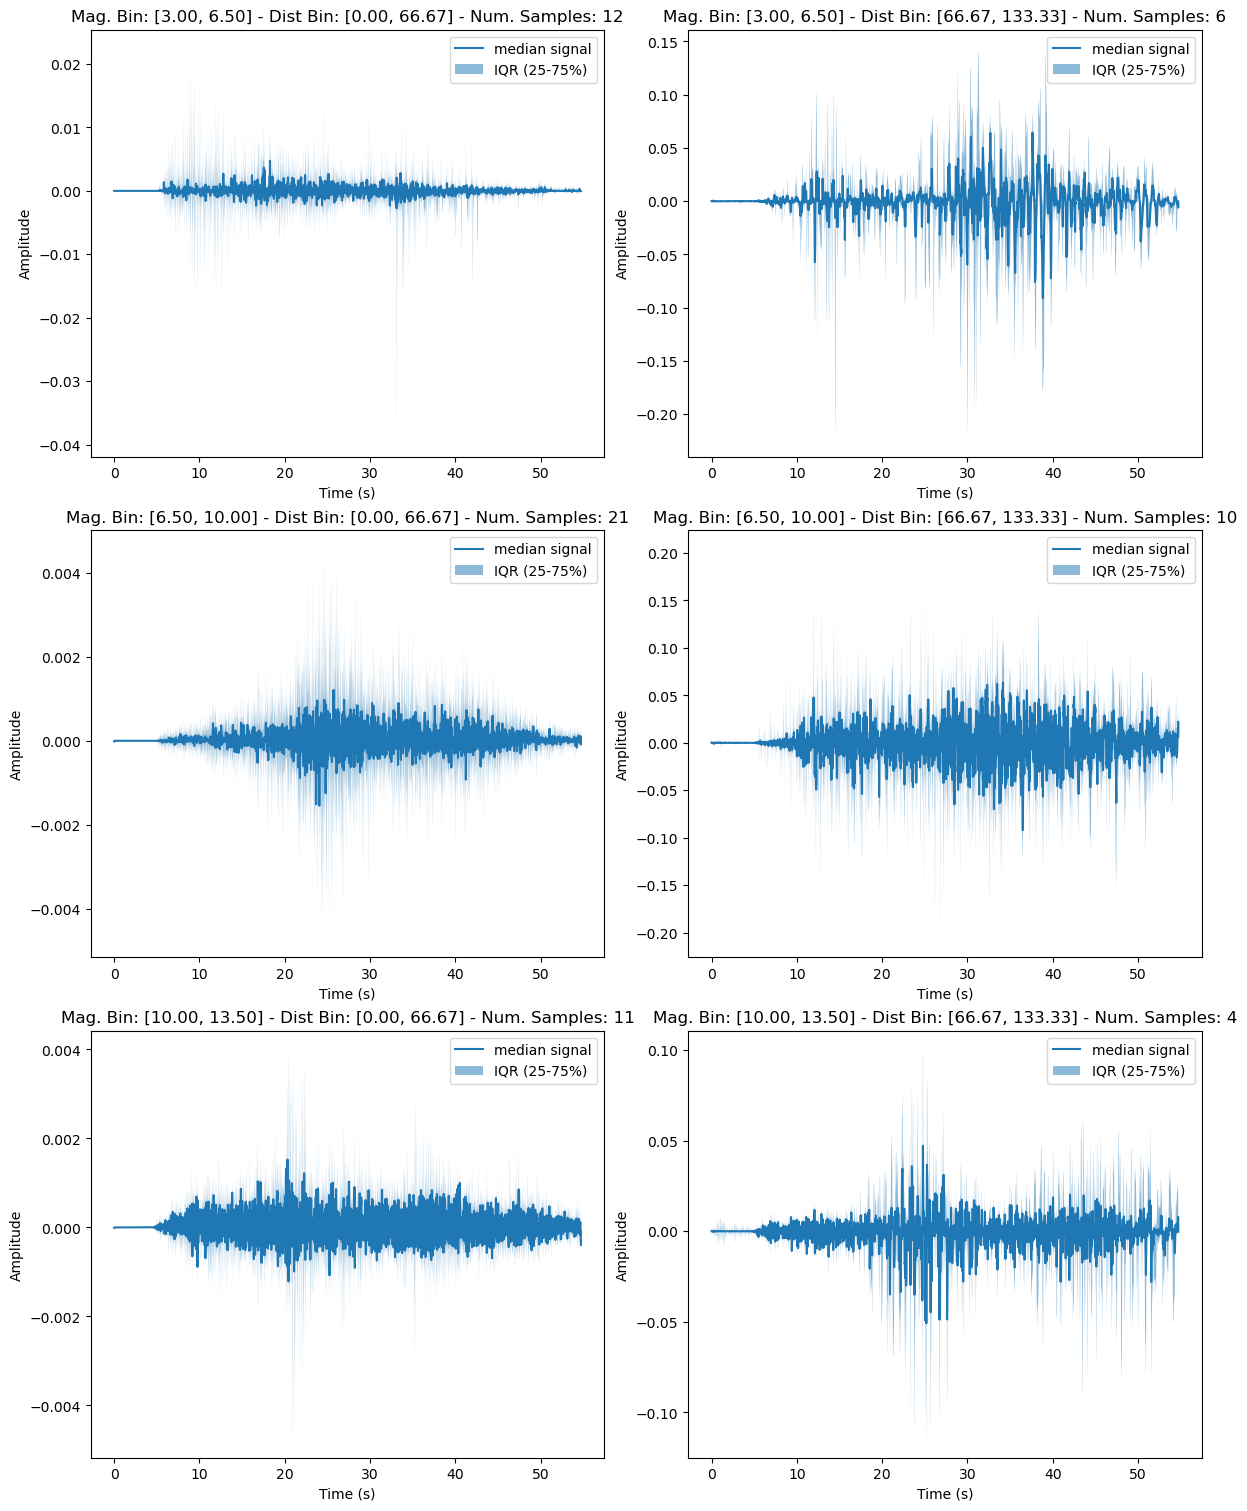

In [26]:
plot_by_bins(data, num_magnitude_bins=2, num_distance_bins=3, plot_type='waveform')

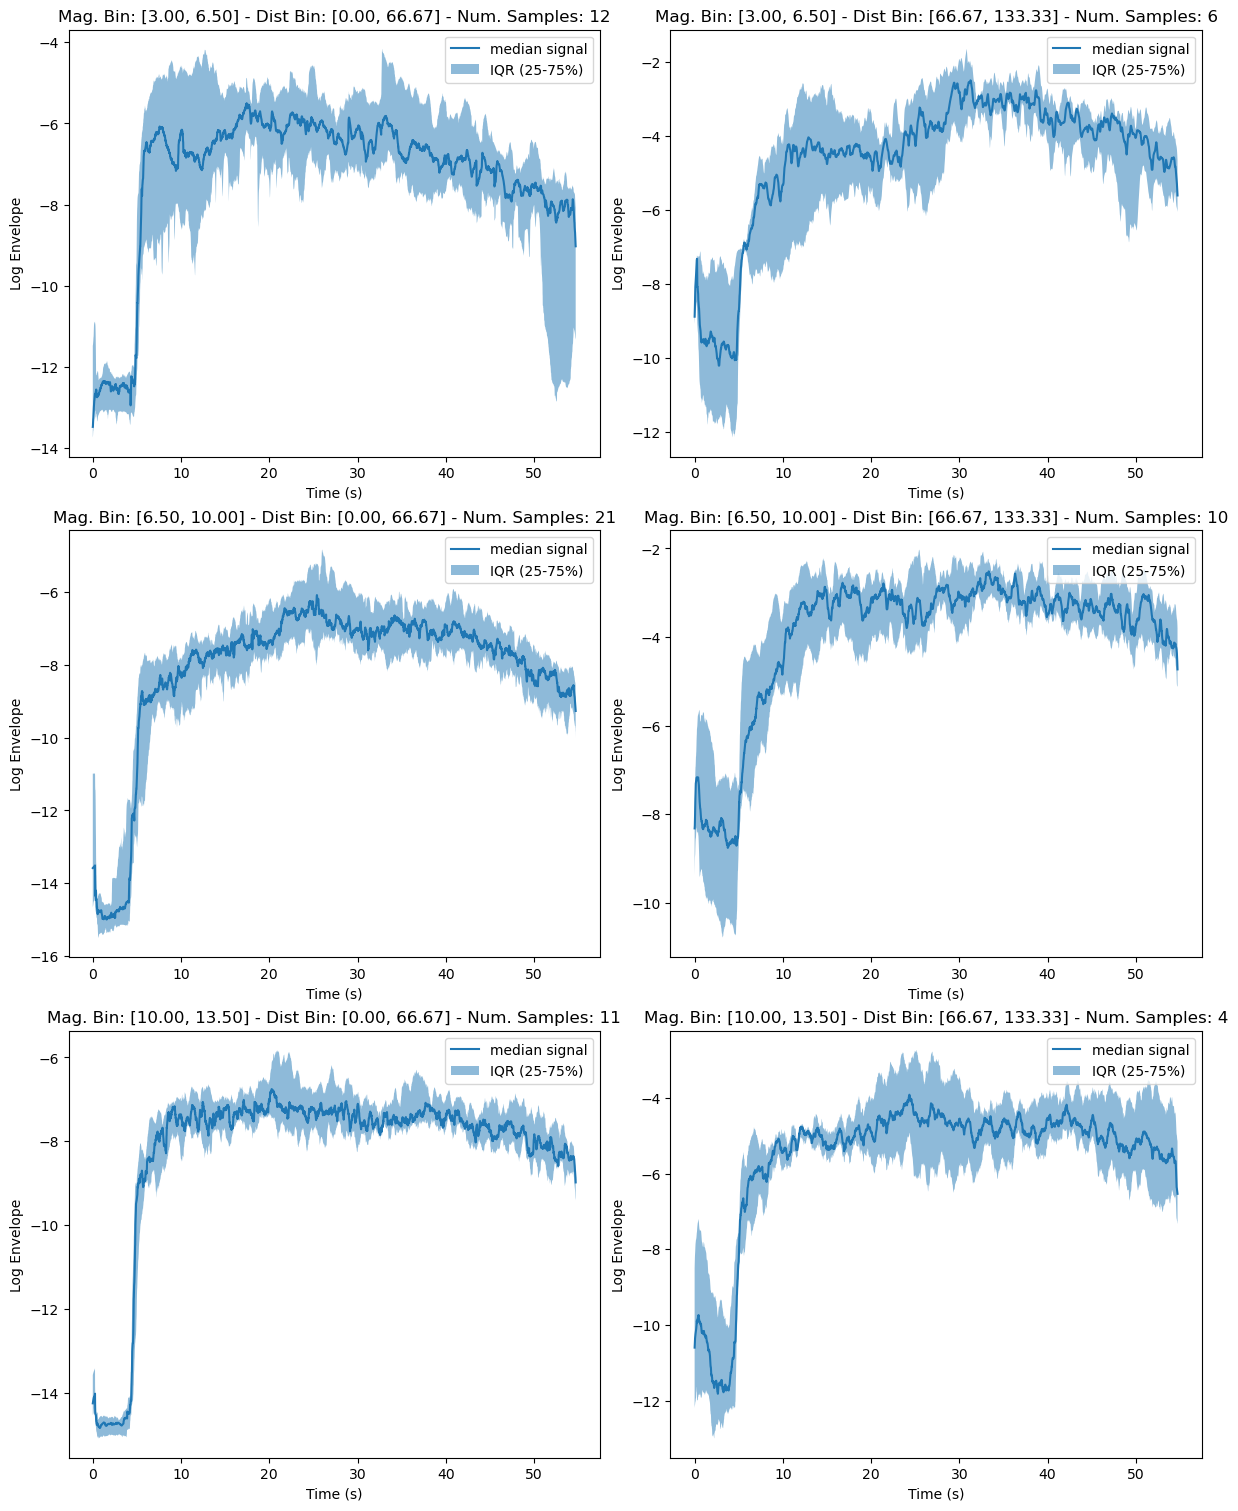

In [27]:
plot_by_bins(data, num_magnitude_bins=2, num_distance_bins=3, plot_type='envelope')

## Evaluation

In [28]:
# Load Test Data
test_dataset_path = config.datasetdir / config.data_test
with h5py.File(test_dataset_path,'r', locking=False) as test_file:
    test_waveforms = test_file["waveform"][:batch_size*8]
    test_features = test_file["features"][:batch_size*8]


In [29]:
test_waveforms.shape, test_features.shape

((512, 3, 5501), (512, 5))

In [34]:
# Generate waveforms with the same conditioning parameters of the test data
pred_data = generate_data(model, model_data_repr, raw_output=False, batch_size=test_features.shape[0], cond_input=test_features, device=device.type)

pred_data['waveforms'].shape

100%|██████████| 1000/1000 [04:09<00:00,  4.01it/s]


(512, 3, 5472)

In [35]:
test_data = {"waveforms": test_waveforms, "cond": test_features}
test_data["waveforms"].shape, test_data["cond"].shape

((512, 3, 5501), (512, 5))

In [50]:
import pickle
with open('plot_dataset','wb') as f: pickle.dump({"test_data": test_data, "pred_data": pred_data}, f)

KeyError: '((21.6, 37.1), (6.1, 7.0))'

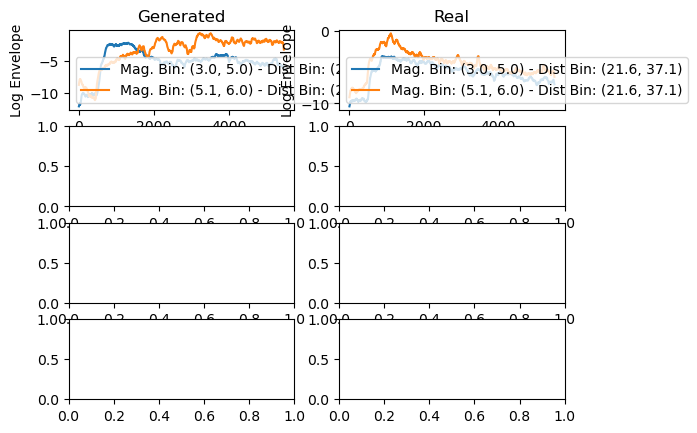

In [38]:
plot_log_envelope_bins(distance_bins = [(21.6, 37.1), (39.0, 48.2), (50.0, 92.0), (93.0, 144.8)], magnitude_bins = [(3.0, 5.0), (5.1, 6.0), (6.1, 7.0)], 
                       channel_index=0,
                        test_data = test_data, 
                        data = pred_data, model = model, model_data_representation = model_data_repr)

In [57]:
# TODO: delete (already updated in utils)
from tqdne.plot import Plot
class PowerSpectralDensityPlot(Plot):
    def __init__(self, fs=100, channel=0, data_representation=None, invert_representation=True):
        super().__init__(channel, data_representation, invert_representation)
        self.fs = fs

    def plot(self, pred, target, cond_signal=None, cond=None):
        # TODO: bad design choice: code is duplicated from metric.py
        pred_psd = np.abs(np.fft.rfft(pred, axis=-1)) ** 2
        target_psd = np.abs(np.fft.rfft(target, axis=-1)) ** 2

        # Compute mean and std of PSD in log scale
        eps = 1e-7
        pred_mean = np.log(pred_psd + eps).mean(axis=0)
        target_mean = np.log(target_psd + eps).mean(axis=0)
        pred_std = np.log(pred_psd + eps).std(axis=0)
        target_std = np.log(target_psd + eps).std(axis=0)

        # Plot
        freq = np.fft.rfftfreq(pred.shape[-1], d=1 / self.fs)
        fig, ax = plt.subplots(figsize=(9, 6))
        ax.plot(freq, pred_mean, "g", label="Predicted")
        ax.fill_between(freq, pred_mean - pred_std, pred_mean + pred_std, color="g", alpha=0.2)
        ax.plot(freq, target_mean, "r", label="Target")
        ax.fill_between(
            freq, target_mean - target_std, target_mean + target_std, color="r", alpha=0.2
        )
        ax.set_title(self.name)
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Log Power")
        ax.legend()
        fig.tight_layout()
        return fig
    
    
class BinPlot(Plot):
    """Creates a bin plot for a given metric."""

    def __init__(
        self,
        metric: Metric,
        num_mag_bins=10,
        num_dist_bins=10,
        min_mag=4.5,
        max_mag=9.5,
        min_dist=0,
        max_dist=180
    ):
        super().__init__(data_representation=None, invert_representation=False)
        self.metric = metric
        self.num_mag_bins = num_mag_bins
        self.num_dist_bins = num_dist_bins
        self.min_mag = min_mag
        self.max_mag = max_mag
        self.min_dist = min_dist
        self.max_dist = max_dist

    @property
    def name(self):
        return f"Bin {self.metric.name}"

    def plot(self, pred, target, cond_signal, cond):
        # extract the magnitude and distance (this is specific to the dataset)
        mags = cond[:, 3]
        dists = cond[:, 0]

        # create the bins
        mag_bins = np.linspace(self.min_mag, self.max_mag, self.num_mag_bins + 1)
        dist_bins = np.linspace(self.min_dist, self.max_dist, self.num_dist_bins + 1)
        results = np.zeros((self.num_dist_bins, self.num_mag_bins))

        # fill the bins
        for i in range(self.num_mag_bins):
            for j in range(self.num_dist_bins):
                mask = (mags >= mag_bins[i]) & (mags < mag_bins[i + 1])
                mask &= (dists >= dist_bins[j]) & (dists < dist_bins[j + 1])
                results[i, j] = self.metric(pred[mask], target[mask])

        # Plotting the heatmap using seaborn
        mag_bins_center = (mag_bins[1:] + mag_bins[:-1]) / 2
        dist_bins_center = (dist_bins[1:] + dist_bins[:-1]) / 2
        fig, ax = plt.subplots(figsize=(8, 8))
        sns.heatmap(
            results,
            annot=True,
            fmt=".1f",
            cmap="viridis",
            xticklabels=[f"{mag:.1f}" for mag in mag_bins_center],
            yticklabels=[f"{dist:.0f}" for dist in dist_bins_center],
        )

        ax.set_xlabel("Magnitude Bin")
        ax.set_ylabel("Distance Bin (in km)")
        ax.set_title(self.name)
        fig.tight_layout()
        return fig    
    

TypeError: float() argument must be a string or a real number, not 'Figure'

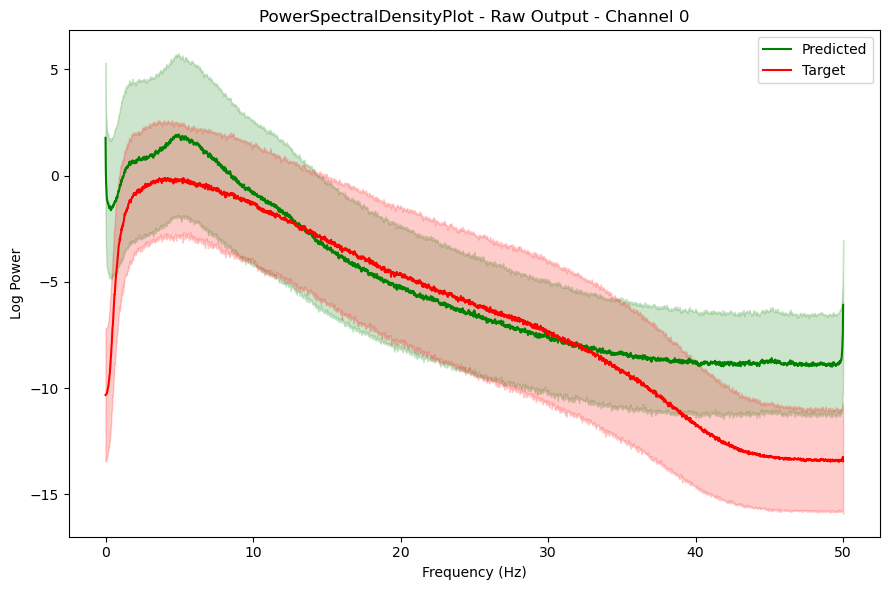

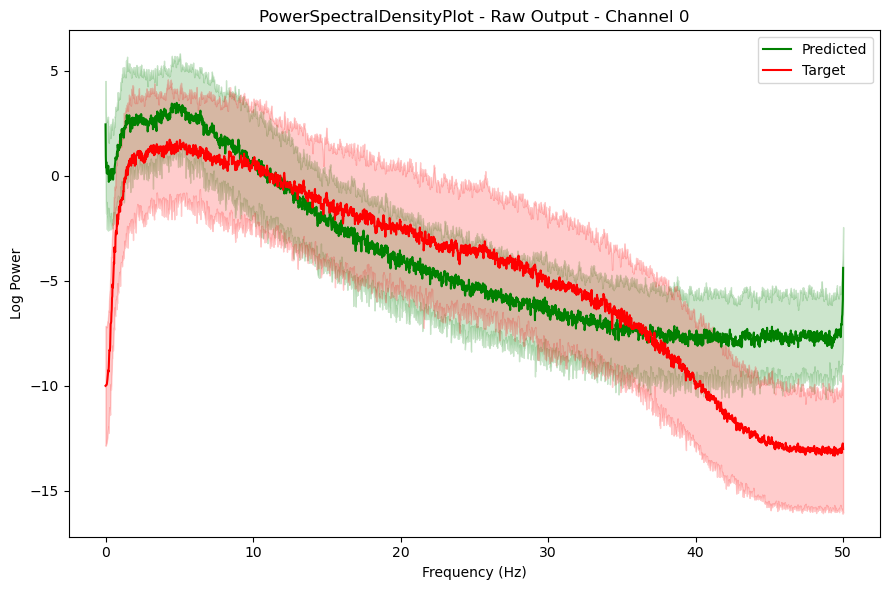

In [58]:
#from tqdne.plot import PowerSpectralDensityPlot, BinPlot

psd_metrics = [PowerSpectralDensityPlot(fs, channel=channel, invert_representation=False) for channel in range(pred_data['waveforms'].shape[1])]

for psd_metric in psd_metrics:
    psd_metric(pred=pred_data['waveforms'], target=test_waveforms[:, :, : pred_data['waveforms'].shape[-1]], cond=test_features).show()
    
    bin_metric = BinPlot(psd_metric, num_mag_bins=3, num_dist_bins=3)
    bin_metric(pred=pred_data['waveforms'], target=test_waveforms[:, :, : pred_data['waveforms'].shape[-1]], cond=test_features).show()
    
    

In [ ]:
from tqdne.metric import LogEnvelope

log_env_metrics = [LogEnvelope(fs, channel=channel, invert_representation=False) for channel in range(pred_waveforms.shape[1])]

for log_env_metric in log_env_metrics:
    log_env_metric.reset()
    log_env_metric.update(pred={"generated": pred_waveforms}, target={"representation": test_waveforms[:, :, : pred_waveforms.shape[-1]], "cond": test_features})
    log_env_metric.plot().show()
    
    bin_metric = BinMetric(log_env_metric, num_mag_bins=3, num_dist_bins=3)
    bin_metric.reset()
    bin_metric.update(pred={"generated": pred_waveforms}, target={"representation": test_waveforms[:, :, : pred_waveforms.shape[-1]], "cond": test_features})
    bin_metric.plot().show()
    

In [ ]:
# TODO: widgets do not work

from tqdne.metric import PowerSpectralDensity, BinMetric
import ipywidgets as widgets
from functools import partial

metrics = {"Power Spectral Density": partial(PowerSpectralDensity, fs=config.fs)}

# Create a dropdown for selecting the metric
metric_dropdown = widgets.Dropdown(
    options=metrics.keys(),
    description='Metric:',
)

# Create a slider for selecting the channel
channel_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=2,
    step=1,
    description='Channel:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


# Bin plot checkbox
bin_plot_checkbox = widgets.Checkbox(
    value=False,
    description='Plot bins',
    disabled=False,
    indent=True,
)

# Create a slider for selecting the number of bins
num_bins_slider = widgets.IntSlider(
    value=10,
    min=1,
    max=50,
    step=1,
    description='Num bins:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Function to update the plot
def update_plot(metric_name, bin_plot, num_bins=10, channel=0):
    metric = metrics[metric_name](channel=channel)
    if bin_plot:
        metric = BinMetric(metric, num_mag_bins=num_bins, num_dist_bins=num_bins)

    # Compute the metric
    metric.reset()
    metric.update(pred={"generated": pred_waveforms}, target={"representation": test_waveforms[:, :, : pred_waveforms.shape[-1]], "cond": test_features})
    metric.plot().show()

# Create interactive plot
widgets.interact(update_plot, metric_name=metric_dropdown, channel=channel_slider, bin_plot=bin_plot_checkbox, num_bins=num_bins_slider)



In [ ]:
print('done')

In [ ]:
# Save the data to obspy format
from obspy import Stream, Trace

# Convert waveforms to Trace objects
traces = [Trace(data=waveform, header={k:v for k, v in get_cond_params_dict(pred_data["cond"][i])}) for i, waveform in enumerate(pred_data["waveforms"])]

# Create a Stream object
st = Stream(traces=traces)

# Save the Stream object to a file
st.write("generated_waveforms.mseed", format="MSEED", reclen=512, encoding="FLOAT64")
